In this notebook we process the data of simulations that find the stable state of a triangular lattice of skyrmions under a magnetic field of different magnitudes.

For the analysis we compute the `mz` average across the film thickness for every simulation.

# Imports

In [4]:
import numpy as np
import oommfpy as op
import matplotlib.pyplot as plt
from pathlib import Path
import re

import matplotlib.patheffects as PathEffects

# Parameters

In [5]:
Ms = 4.60545e5
A = 7.875e-12
# A = 6e-12
D = 0.6e-3
LD = 4 * np.pi * A / D

# Skyrmion lattice

In [5]:
!head ../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm.out/table.txt

# t (s)	mx ()	my ()	mz ()	E_total (J)	B_extx (T)	B_exty (T)	B_extz (T)	E_exch (J)	maxTorque (T)
0	-4.7683715e-11	1.453218e-10	-0.17004044	-1.2000436e-15	0	0	-0.019999996	-3.05468e-15	0.5919127
5.00335604614566e-10	1.0717482e-09	-4.7229587e-10	-0.09189044	-2.8755494e-15	0	0	-0.019999996	-3.1474228e-15	0.01680161
1.0001991617312598e-09	2.756573e-09	-1.0172526e-09	-0.086817026	-2.9287475e-15	0	0	-0.019999996	-3.1759327e-15	0.039870985
1.5007163504396689e-09	5.63122e-10	-4.359654e-09	-0.082525864	-2.977775e-15	0	0	-0.019999996	-3.1873951e-15	0.031305384
2.001384345799234e-09	-9.264265e-10	-4.613967e-09	-0.07940608	-3.0102695e-15	0	0	-0.019999996	-3.1876827e-15	0.013585393
2.5015020502277447e-09	-1.8210639e-09	-3.960019e-09	-0.07665463	-3.0293932e-15	0	0	-0.019999996	-3.1932577e-15	0.013966969
3e-09	-2.9211953e-09	-3.6057972e-09	-0.0744205	-3.043816e-15	0	0	-0.019999996	-3.2005047e-15	0.016324427
3e-09	1.8410455e-08	-4.007383e-05	-0.07447835	-3.101117e-15	0	0	-0.019999996	-3.2362802e-15	3.3

## Field relaxation

In [27]:
mz_average = {}

BASEDIR = Path('../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm.out/')
# print(list(BASEDIR.glob('*.ovf')))
for bz in np.arange(-40, -261, -20):

    FILE = BASEDIR / f'm_skX_Bz_-{abs(bz):05d}_mT.ovf'
    # if not FILE.exists():
    #     continue

    data = op.MagnetisationData(FILE)
    data.generate_coordinates()
    data.generate_field()
    mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

    mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
    for z_idx in range(mz_3d.shape[0]):
        mz_av += mz_3d[z_idx, :, :]

    mz_av /= mz_3d.shape[0]

    mz_average[bz] = mz_av

In [28]:
# PLOTDIR_FS = PLOTDIR / f'two_tubes_field-sweep_DOWN'
# PLOTDIR_FS.mkdir(exist_ok=True)
# for by in np.arange(-100, -4, 5):
#     np.savetxt(PLOTDIR_FS / f'm_field-sweep_By_{by:06d}.txt', mz_average_down[by])

In [29]:
sorted(mz_average.keys(), reverse=True)

[-40, -60, -80, -100, -120, -140, -160, -180, -200, -220, -240, -260]

In [30]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [31]:
PLOTDIR = Path('sk_lattice_field-relax_Bz')
PLOTDIR.mkdir(exist_ok=True)

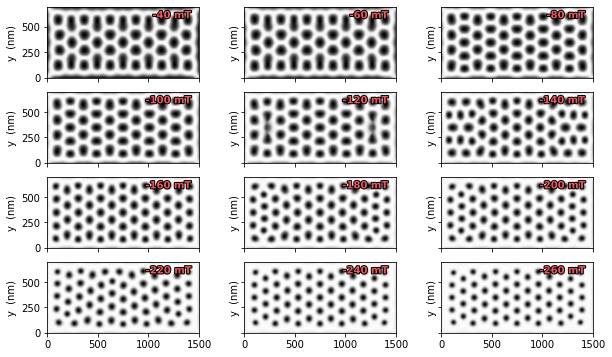

In [41]:
f, axs = plt.subplots(figsize=(10, 6), ncols=3, nrows=4, sharex=True, sharey=True)

for b, bz in enumerate(np.arange(-40, -261, -20)):
    
    ax = axs.flat[b]
    ax.imshow(mz_average[bz], cmap='Greys', **im_tubes_args)
    # axs[b][p].set_xlabel('x  (nm)')
    # axs[b][p].set_ylabel('y  (nm)')
    # axs[b][p].set_title(f'Field: {by} mT')

    t = ax.text(0.95, 0.95, f'{bz} mT', ha='right', va='top',
                transform=ax.transAxes, 
                rotation=0, color='#EB5660', fontweight='bold')

    t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    ax.set_ylabel('y  (nm)')

    if b >= 18:
        ax.set_xlabel('x  (nm)')

#     if b == 0:
#         magpms = PARAMS.split('_')
#         Ms = 4.60545e5
#         d = float((magpms[1]).replace('d', '.'))
#         a = float((magpms[3]).replace('d', '.'))
#         BD = (d ** 2) / (2 * Ms * a)
#         axs[b][p].set_title(f'D = {d * 1e3:.2f} mJ/m^2 \n A = {a * 1e12:.2f} pJ/m \n µ0 H_D = {BD:.4f} T')

# plt.tight_layout()
plt.savefig(PLOTDIR / f'mz_average_field-relax.png', dpi=200, bbox_inches='tight')
plt.show()

In [42]:
for k in mz_average.keys():
    np.save(PLOTDIR / f'mz_average_Bz_{k:06d}.npy', mz_average[k])

In [39]:
for k in mz_average.keys():
    print(mz_average[k].min())

-0.994432883707798
-0.996715784129429
-0.995755128110595
-0.9968941681705752
-0.9982216219747885
-0.9990169223654657
-0.9974449539164925
-0.9992441199369269
-0.9984544562788609
-0.9999704467511679
-0.9992679767915172
-0.9988611400508394


# Skyrmion lattice rotated

In [3]:
!head ../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm_ROT.out/table.txt

# t (s)	mx ()	my ()	mz ()	E_total (J)	B_extx (T)	B_exty (T)	B_extz (T)	E_exch (J)	maxTorque (T)
0	1.6802833e-10	-5.5631003e-11	-0.19329552	-1.1127167e-15	0	0	-0.019999996	-3.0277097e-15	0.7653554
5.01537360388687e-10	0	2.0799182e-09	-0.093474746	-2.9553594e-15	0	0	-0.019999996	-3.1861864e-15	0.03461146
1.0014323226452156e-09	-7.7883405e-10	1.852853e-09	-0.09026	-2.9800497e-15	0	0	-0.019999996	-3.1873441e-15	0.014804701
1.5006607687355589e-09	-1.2094066e-09	1.1080787e-09	-0.08829372	-2.990684e-15	0	0	-0.019999996	-3.1869483e-15	0.009903542
2.0009141714227937e-09	-1.1705217e-09	9.445917e-10	-0.08696057	-2.9965366e-15	0	0	-0.019999996	-3.1870436e-15	0.007021978
2.501043815779246e-09	-1.0127112e-09	1.1989049e-09	-0.08605249	-3.0004577e-15	0	0	-0.019999996	-3.1868774e-15	0.0071724965
3e-09	-8.764721e-10	1.0626656e-09	-0.08539187	-3.0034454e-15	0	0	-0.019999996	-3.1864687e-15	0.0066148615
3e-09	-3.2356806e-09	-1.6621181e-09	-0.08292394	-3.024859e-15	0	0	-0.019999996	-3.1886636e-15	2.2537718e

## Field relaxation

In [4]:
mz_average = {}

BASEDIR = Path('../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm_ROT.out/')
# print(list(BASEDIR.glob('*.ovf')))
for bz in np.arange(-40, -261, -20):

    FILE = BASEDIR / f'm_skX_Bz_-{abs(bz):05d}_mT.ovf'
    # if not FILE.exists():
    #     continue

    data = op.MagnetisationData(FILE)
    data.generate_coordinates()
    data.generate_field()
    mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

    mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
    for z_idx in range(mz_3d.shape[0]):
        mz_av += mz_3d[z_idx, :, :]

    mz_av /= mz_3d.shape[0]

    mz_average[bz] = mz_av

In [28]:
# PLOTDIR_FS = PLOTDIR / f'two_tubes_field-sweep_DOWN'
# PLOTDIR_FS.mkdir(exist_ok=True)
# for by in np.arange(-100, -4, 5):
#     np.savetxt(PLOTDIR_FS / f'm_field-sweep_By_{by:06d}.txt', mz_average_down[by])

In [5]:
sorted(mz_average.keys(), reverse=True)

[-40, -60, -80, -100, -120, -140, -160, -180, -200, -220, -240, -260]

In [6]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [7]:
PLOTDIR = Path('sk_lattice_field-relax_Bz_ROT')
PLOTDIR.mkdir(exist_ok=True)

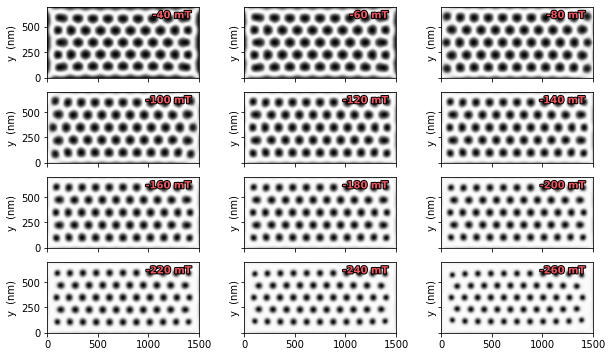

In [8]:
f, axs = plt.subplots(figsize=(10, 6), ncols=3, nrows=4, sharex=True, sharey=True)

for b, bz in enumerate(np.arange(-40, -261, -20)):
    
    ax = axs.flat[b]
    ax.imshow(mz_average[bz], cmap='Greys', **im_tubes_args)
    # axs[b][p].set_xlabel('x  (nm)')
    # axs[b][p].set_ylabel('y  (nm)')
    # axs[b][p].set_title(f'Field: {by} mT')

    t = ax.text(0.95, 0.95, f'{bz} mT', ha='right', va='top',
                transform=ax.transAxes, 
                rotation=0, color='#EB5660', fontweight='bold')

    t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    ax.set_ylabel('y  (nm)')

    if b >= 18:
        ax.set_xlabel('x  (nm)')

#     if b == 0:
#         magpms = PARAMS.split('_')
#         Ms = 4.60545e5
#         d = float((magpms[1]).replace('d', '.'))
#         a = float((magpms[3]).replace('d', '.'))
#         BD = (d ** 2) / (2 * Ms * a)
#         axs[b][p].set_title(f'D = {d * 1e3:.2f} mJ/m^2 \n A = {a * 1e12:.2f} pJ/m \n µ0 H_D = {BD:.4f} T')

# plt.tight_layout()
plt.savefig(PLOTDIR / f'mz_average_field-relax.png', dpi=200, bbox_inches='tight')
plt.show()

In [9]:
for k in mz_average.keys():
    np.save(PLOTDIR / f'mz_average_Bz_{k:06d}.npy', mz_average[k])

In [10]:
for k in mz_average.keys():
    print(mz_average[k].min())

-0.9963757908493689
-0.997803000362153
-0.9994411573844395
-0.9993465385397438
-0.9991450457499823
-0.9988861766634114
-0.9989123963811201
-0.9994001378261966
-0.999523504165999
-0.9991329793694741
-0.9996228053738377
-0.9993716485251394


# Skyrmion lattice rotated with anisotropy

In [2]:
!head ../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm_ROT_anisotropy_x-hard-axis_4kJm3.out/table.txt

# t (s)	mx ()	my ()	mz ()	Ku1 (J/m3)	E_total (J)	B_extx (T)	B_exty (T)	B_extz (T)	E_exch (J)	maxTorque (T)
0	1.5894572e-10	-5.5631003e-11	-0.19329554	-4000	-8.84345e-16	0	0	-0.019999996	-3.0277097e-15	0.7608646
5.010895987596903e-10	6.766546e-10	1.9618442e-09	-0.09351935	-4000	-2.702052e-15	0	0	-0.019999996	-3.1788467e-15	0.03277625
1.0012605557590877e-09	6.6303074e-10	2.252488e-09	-0.08959381	-4000	-2.7299055e-15	0	0	-0.019999996	-3.1817848e-15	0.019998876
1.5002628284182693e-09	5.052203e-10	1.2352354e-09	-0.087170005	-4000	-2.742424e-15	0	0	-0.019999996	-3.1826924e-15	0.011457002
2.0014832520317403e-09	8.151645e-10	9.718395e-10	-0.08570106	-4000	-2.7489294e-15	0	0	-0.019999996	-3.1836284e-15	0.007708485
2.500576995705596e-09	5.1997956e-10	6.993612e-10	-0.08483618	-4000	-2.753328e-15	0	0	-0.019999996	-3.1840934e-15	0.008238213
3e-09	7.311503e-10	5.812872e-10	-0.084265836	-4000	-2.7568445e-15	0	0	-0.019999996	-3.1840665e-15	0.007482216
3e-09	1.3010842e-08	1.685733e-08	-0.08323303	-4000

## Field relaxation

In [6]:
mz_average = {}

BASEDIR = Path('../sims/mumax3/skyrmion_lattice_Co8Zn9Mn3/sk_lattice_D_0d6e-3_A_5d7295e-12_LD_120nm_ROT_anisotropy_x-hard-axis_4kJm3.out/')
# print(list(BASEDIR.glob('*.ovf')))
for bz in np.arange(-40, -261, -20):

    FILE = BASEDIR / f'm_skX_Bz_-{abs(bz):05d}_mT.ovf'
    # if not FILE.exists():
    #     continue

    data = op.MagnetisationData(FILE)
    data.generate_coordinates()
    data.generate_field()
    mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

    mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
    for z_idx in range(mz_3d.shape[0]):
        mz_av += mz_3d[z_idx, :, :]

    mz_av /= mz_3d.shape[0]

    mz_average[bz] = mz_av

In [28]:
# PLOTDIR_FS = PLOTDIR / f'two_tubes_field-sweep_DOWN'
# PLOTDIR_FS.mkdir(exist_ok=True)
# for by in np.arange(-100, -4, 5):
#     np.savetxt(PLOTDIR_FS / f'm_field-sweep_By_{by:06d}.txt', mz_average_down[by])

In [7]:
sorted(mz_average.keys(), reverse=True)

[-40, -60, -80, -100, -120, -140, -160, -180, -200, -220, -240, -260]

In [8]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [9]:
PLOTDIR = Path('sk_lattice_field-relax_Bz_ROT_anisotropy')
PLOTDIR.mkdir(exist_ok=True)

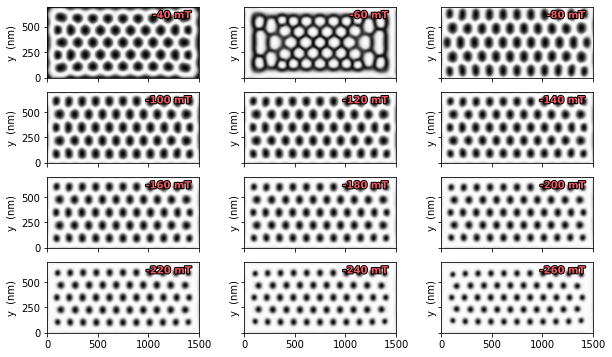

In [10]:
f, axs = plt.subplots(figsize=(10, 6), ncols=3, nrows=4, sharex=True, sharey=True)

for b, bz in enumerate(np.arange(-40, -261, -20)):
    
    ax = axs.flat[b]
    ax.imshow(mz_average[bz], cmap='Greys', **im_tubes_args)
    # axs[b][p].set_xlabel('x  (nm)')
    # axs[b][p].set_ylabel('y  (nm)')
    # axs[b][p].set_title(f'Field: {by} mT')

    t = ax.text(0.95, 0.95, f'{bz} mT', ha='right', va='top',
                transform=ax.transAxes, 
                rotation=0, color='#EB5660', fontweight='bold')

    t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    ax.set_ylabel('y  (nm)')

    if b >= 18:
        ax.set_xlabel('x  (nm)')

#     if b == 0:
#         magpms = PARAMS.split('_')
#         Ms = 4.60545e5
#         d = float((magpms[1]).replace('d', '.'))
#         a = float((magpms[3]).replace('d', '.'))
#         BD = (d ** 2) / (2 * Ms * a)
#         axs[b][p].set_title(f'D = {d * 1e3:.2f} mJ/m^2 \n A = {a * 1e12:.2f} pJ/m \n µ0 H_D = {BD:.4f} T')

# plt.tight_layout()
plt.savefig(PLOTDIR / f'mz_average_field-relax_anis-x-hard-axis.png',
            dpi=200, bbox_inches='tight')
plt.show()

In [11]:
for k in mz_average.keys():
    np.save(PLOTDIR / f'mz_average_anis-x-hard-axis_By_{k:06d}.npy', mz_average[k])

In [10]:
for k in mz_average.keys():
    print(mz_average[k].min())

-0.9963757908493689
-0.997803000362153
-0.9994411573844395
-0.9993465385397438
-0.9991450457499823
-0.9988861766634114
-0.9989123963811201
-0.9994001378261966
-0.999523504165999
-0.9991329793694741
-0.9996228053738377
-0.9993716485251394
